<a href="https://colab.research.google.com/github/kyulee-jeon/kyulee-jeon/blob/main/Week11ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Residual block

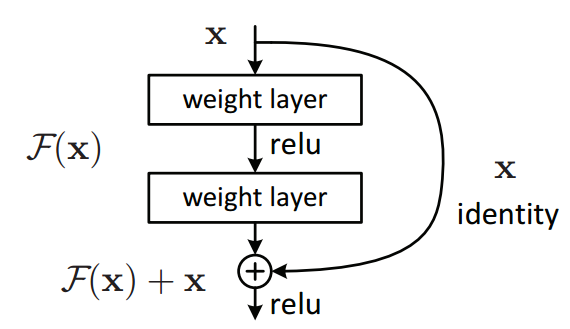

F(x) : weight layer => relu => weight layer 

x : identity

Ref: He et al., Deep Residual Learning for Image Recognition, 2015

Residual block 은 Plain deep neural network에서 model이 복잡해지고, layer 구조가 깊어질수록 발생하는 vanishing gradient 및 over-fitting의 문제점을 해결하며, ILSVRC Challenge에서 사람보다 뛰어난 성능을 보였으며, 이후의 vision CNN 모델들에도 지속적으로 영향을 끼침

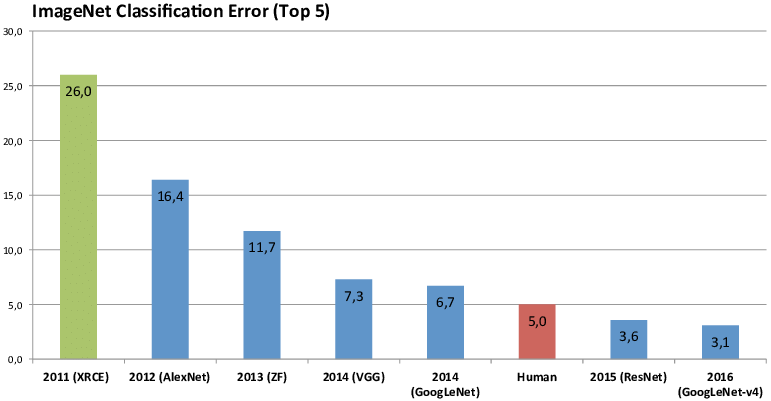

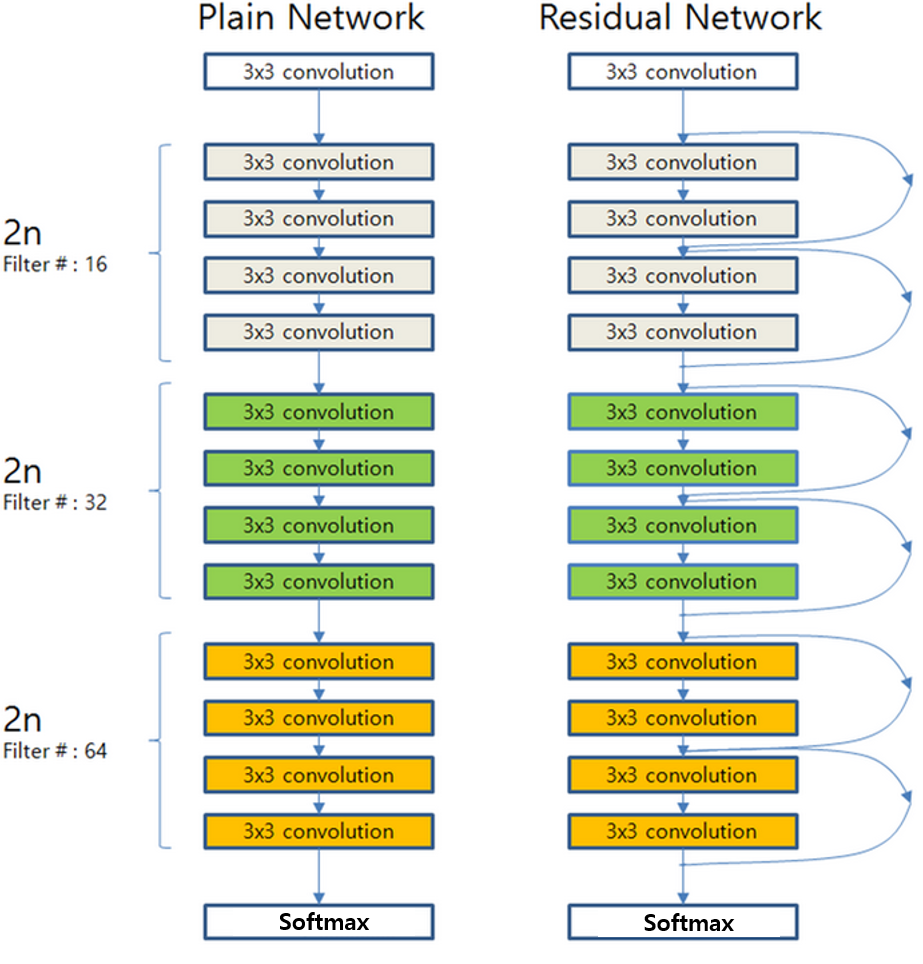

**Data Loading**

In [1]:
#Connection to GoogleDrive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
from glob import glob
import numpy as np
import pickle

In [3]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/2022MedicalMachineLearning/data/COVID-19_Radiography_Dataset"
"""
#Define the file paths
all_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]
#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]
all_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]
# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths
"""


"\n#Define the file paths\nall_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]\n#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]\nall_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]\n# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths\n"

In [5]:
#Unzip the data
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/2022MedicalMachineLearning/data/COVID-19_Radiography_Dataset.zip"

In [7]:
#load the list
with open(os.path.join(data_path, "list_x_wk10.pickle"), "rb") as f:
  list_x = pickle.load(f)
with open(os.path.join(data_path, "list_y_wk10.pickle"), "rb") as f:
  list_y = pickle.load(f)

In [8]:
#Gray scale to RGB
import cv2
list_x = list(map(lambda x: cv2.cvtColor(x,cv2.COLOR_GRAY2RGB), list_x))

In [9]:
#convert to ndarray of the data
data_x = np.array(list_x)
data_y = np.array(list_y)

In [10]:
#save the array
"""
with open(os.path.join(data_path, "data_x_wk11"), "wb") as f:
  pickle.dump(data_x, f)
with open(os.path.join(data_path, "list_y_wk11"), "wb") as f:
  pickle.dump(data_y, f)
"""

'\nwith open(os.path.join(data_path, "data_x_wk11"), "wb") as f:\n  pickle.dump(data_x, f)\nwith open(os.path.join(data_path, "list_y_wk11"), "wb") as f:\n  pickle.dump(data_y, f)\n'

In [11]:
print("The length of list_x is {}".format(len(list_x)))
print("The length of list_y is {}".format(len(list_y)))
print("The shape of first element of list_x is {}".format(list_x[0].shape))

del list_x, list_y

The length of list_x is 3984
The length of list_y is 3984
The shape of first element of list_x is (299, 299, 3)


In [12]:
#one hot encoding
data_y_ = data_y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(data_y_)
data_y = ohe.transform(data_y_)

Data Preprocessing

In [13]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [14]:
# split into train, validation, and test sets (stratified)
#how to split validation and test
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

random_seed = 11
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

from sklearn.model_selection import train_test_split
x_train, x_val_test, y_train, y_val_test = train_test_split(data_x, data_y, 
                                                            test_size = val_prop+test_prop, 
                                                            random_state = random_seed, 
                                                            stratify = data_y)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = test_prop/(val_prop+test_prop),
                                                random_state = random_seed,
                                                stratify = y_val_test)

In [15]:
#https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
#https://discuss.pytorch.org/t/apply-transform-on-numpy-arrays/19106/9
#https://wikidocs.net/157285
#https://stackoverflow.com/questions/46586616/pytorch-trying-to-apply-the-transform-to-a-numpy-array-fails-with-an-error
#https://076923.github.io/posts/Python-pytorch-11/
class FromNPDataset(torch.utils.data.Dataset):
  def __init__(self, x, y, transform = None):
    self.x = x
    self.y = y
    self.transform = transform
    
  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]
    
    if self.transform:
      x = self.transform(x)
    else: 
      x = torch.FloatTensor(x)

    y = torch.Tensor(y)
    
    return x, y

  def __len__(self):
    return len(self.y)

In [16]:
#from torchvision.transforms.transforms import ToPILImage

#Statistics Based on ImageNet Data for Normalisation (channel, width, height)
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {'train':transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)), #Resizes all images into same dimension
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.RandomRotation(15), # Rotates the images upto Max of 10 Degrees
                                # transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    'val': transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)),
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                                ]),
                    'test': transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)),
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                                ])
                    }


In [17]:
#Prepare torch dataset

#ds_train = FromNPDataset(x_train, y_train, transform = None)
#ds_val = FromNPDataset(x_val, y_val, transform = None)
#ds_test = FromNPDataset(x_test, y_test, transform = None)

ds_train = FromNPDataset(x_train, y_train, transform = data_transforms['train'])
ds_val = FromNPDataset(x_val, y_val, transform = data_transforms['val'])
ds_test = FromNPDataset(x_test, y_test, transform = data_transforms['test'])

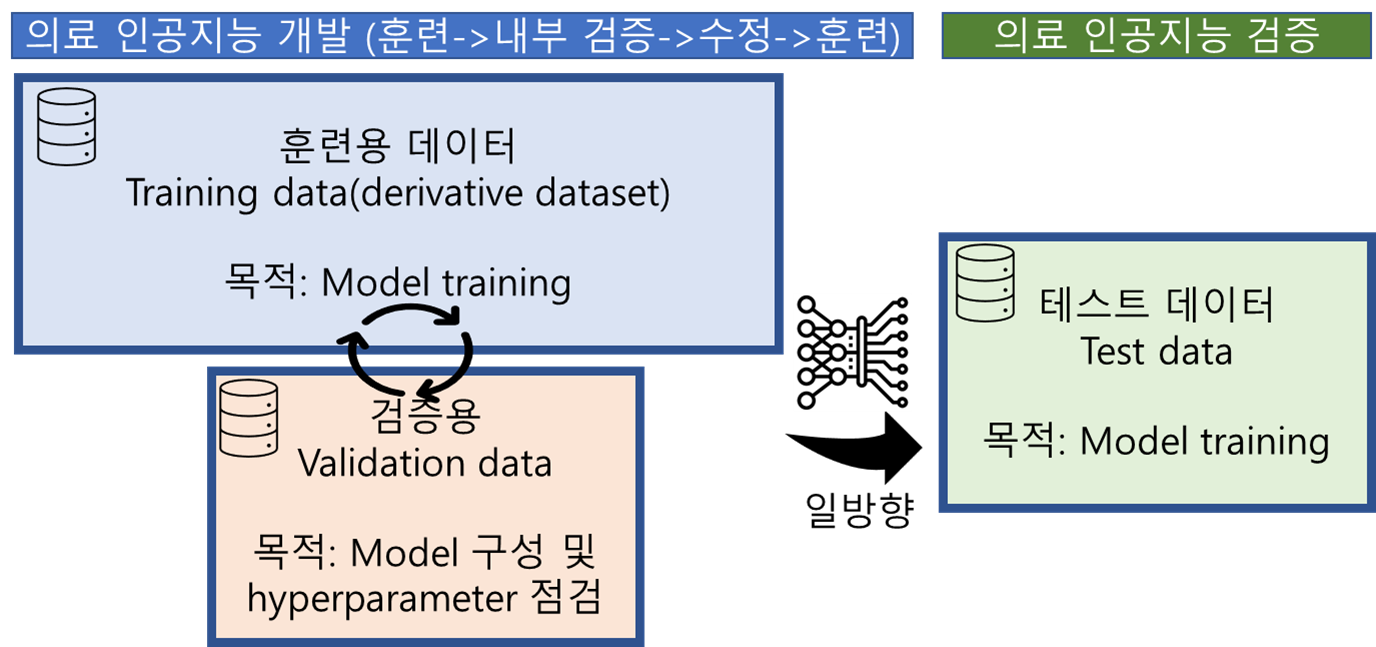

**Defining the model**

In [18]:
import torchvision.models as models

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [20]:
output_dim = 2
intput_channel = 3
input_dim = 299*299*3

In [21]:
from torch import nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3,
                           stride = stride, padding =1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3,
                           stride = 1, padding =1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channel != out_channel:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channel, out_channel,
                    kernel_size=1, stride=stride, bias = False),
          nn.BatchNorm2d(out_channel)
      )
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x)
    out = F.relu(out)
    return out

In [22]:
class ResNet(nn.Module):
  def __init__(self, num_classes = 2):
    super(ResNet, self).__init__()
    self.conv0 = nn.Conv2d(in_channels = 3,
                             out_channels = 3, 
                             kernel_size = 8, 
                             stride = 1)
    
    self.in_channel = 16
    
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 3,
                           stride = 1, padding =1, bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16, 2, stride = 1)
    self.layer2 = self._make_layer(32, 2, stride = 2)
    self.layer3 = self._make_layer(64, 2, stride = 2)
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, out_channel, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channel, out_channel, stride))
      self.in_channel = out_channel
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv0(x)  #299*299*3 -> #292*292*3
    x = F.max_pool2d(x, 8) # 36*36*3
    x = F.relu(x)
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 8)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [23]:
"""
W = 299 #no. of dimension
K = 5 #kernel
P = 0 #padding
S = 1 #stride
M = 2 max pooling

W = ((W - K + 2*P)/S)+1
W = W/M #after max pooling
"""

'\nW = 299 #no. of dimension\nK = 5 #kernel\nP = 0 #padding\nS = 1 #stride\nM = 2 max pooling\n\nW = ((W - K + 2*P)/S)+1\nW = W/M #after max pooling\n'

In [24]:
model = ResNet().to(device)

In [25]:
print(model)

ResNet(
  (conv0): Conv2d(3, 3, kernel_size=(8, 8), stride=(1, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [26]:
from torchsummary import summary
summary(model, input_size = (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 292, 292]             579
            Conv2d-2           [-1, 16, 36, 36]             432
       BatchNorm2d-3           [-1, 16, 36, 36]              32
            Conv2d-4           [-1, 16, 36, 36]           2,304
       BatchNorm2d-5           [-1, 16, 36, 36]              32
            Conv2d-6           [-1, 16, 36, 36]           2,304
       BatchNorm2d-7           [-1, 16, 36, 36]              32
        BasicBlock-8           [-1, 16, 36, 36]               0
            Conv2d-9           [-1, 16, 36, 36]           2,304
      BatchNorm2d-10           [-1, 16, 36, 36]              32
           Conv2d-11           [-1, 16, 36, 36]           2,304
      BatchNorm2d-12           [-1, 16, 36, 36]              32
       BasicBlock-13           [-1, 16, 36, 36]               0
           Conv2d-14           [-1, 32,

모델구조
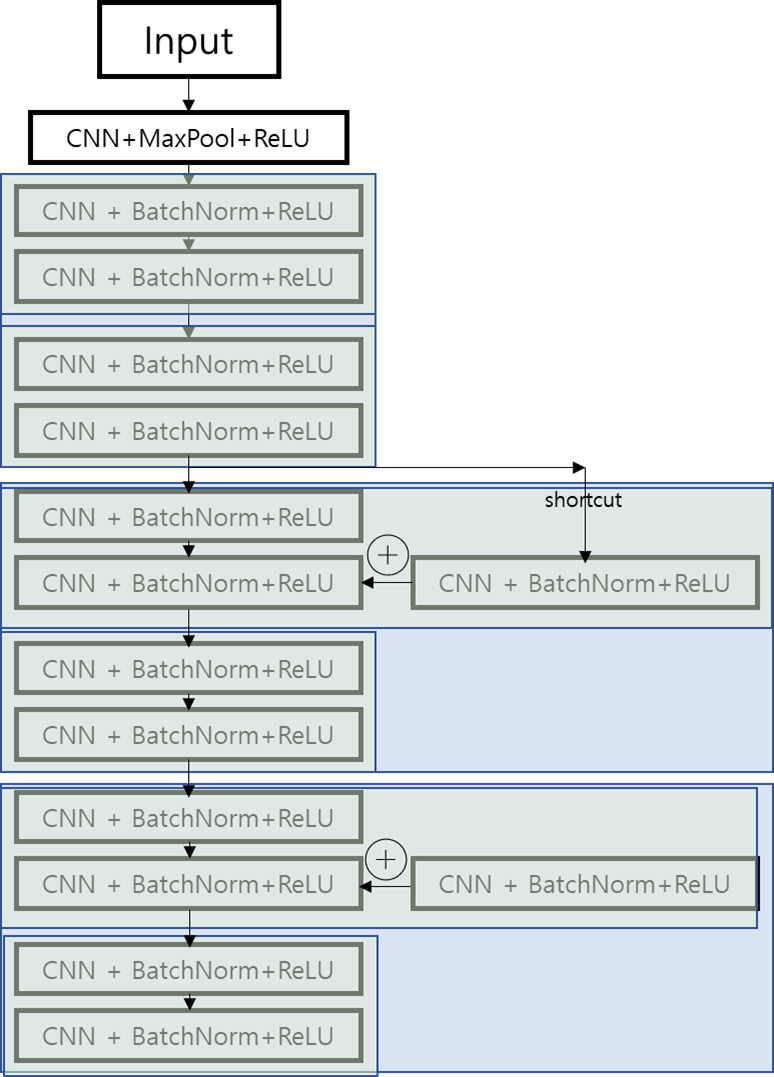

**Configuration of Training**

In [27]:
batch_size = 128
epochs = 50
learning_rate = 0.01

In [28]:
optimizer = torch.optim.SGD(model.parameters(), 
                            lr = learning_rate,
                            weight_decay = 0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.1)

In [29]:
train_loader = torch.utils.data.DataLoader(
    dataset = ds_train,
    batch_size = batch_size,
    shuffle = True
)
val_loader = torch.utils.data.DataLoader(
    dataset = ds_val,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = ds_test,
    batch_size = batch_size,
    shuffle = True
)

In [30]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send the data to device
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [31]:
def evaluate(model, loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum of all loss values
            loss += F.cross_entropy(output, target,reduction='sum').item()
            
            # the class with the maximal value is the predicted value
            pred = output.max(1, keepdim=True)[1]
            target_label = target.max(1, keepdim=True)[1]
            correct += (target_label==pred).sum().item()
            
    loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    return loss, accuracy

**Fitting the model**

In [32]:
val_loss_ = []
val_accuracy_ = []
for epoch in range(epochs):
  scheduler.step()
  train(model, train_loader, optimizer)
  val_loss, val_accuracy = evaluate(model, val_loader)
  val_loss_.append(val_loss)
  val_accuracy_.append(val_accuracy)

  print('[{}] Validation Loss: {:.4f}, Accuracy: {:.2f}%'. format(epoch, val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[0] Validation Loss: 0.3602, Accuracy: 90.84%
[1] Validation Loss: 0.2717, Accuracy: 90.84%
[2] Validation Loss: 0.2291, Accuracy: 91.09%
[3] Validation Loss: 0.2209, Accuracy: 93.35%
[4] Validation Loss: 0.2223, Accuracy: 92.85%
[5] Validation Loss: 0.2018, Accuracy: 93.98%
[6] Validation Loss: 0.3314, Accuracy: 89.34%
[7] Validation Loss: 0.2108, Accuracy: 93.22%
[8] Validation Loss: 0.2838, Accuracy: 91.34%
[9] Validation Loss: 0.1933, Accuracy: 93.48%
[10] Validation Loss: 0.1720, Accuracy: 94.98%
[11] Validation Loss: 0.1812, Accuracy: 93.85%
[12] Validation Loss: 0.1606, Accuracy: 95.36%
[13] Validation Loss: 0.1577, Accuracy: 95.48%
[14] Validation Loss: 0.1881, Accuracy: 92.72%
[15] Validation Loss: 0.1782, Accuracy: 94.60%
[16] Validation Loss: 0.1580, Accuracy: 95.61%
[17] Validation Loss: 0.1524, Accuracy: 95.98%
[18] Validation Loss: 0.1582, Accuracy: 95.36%
[19] Validation Loss: 0.2654, Accuracy: 93.10%
[20] Validation Loss: 0.1498, Accuracy: 96.11%
[21] Validation Loss: 0

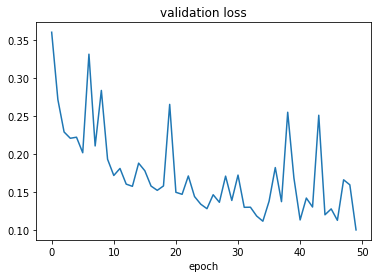

In [33]:
import matplotlib.pyplot as plt
plt.plot(val_loss_)
plt.title("validation loss")
plt.xlabel("epoch")
plt.show()

In [34]:
torch.save(model.state_dict(), os.path.join(data_path, "wk11_my_ResNet.pth"))

In [35]:
model.load_state_dict(torch.load(os.path.join(data_path, "wk11_my_ResNet.pth")))

<All keys matched successfully>

In [36]:
test_loss, test_accuracy = evaluate(model, test_loader)
print('Performance of my ResNet \n Test Loss: {:.4f}, Accuracy: {:.2f}%'. format(test_loss, test_accuracy))

Performance of my ResNet 
 Test Loss: 0.1193, Accuracy: 96.36%
